In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
sns.set("notebook", style="white")

In [4]:
delta_t = 2
x_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
x_plot = np.linspace(-2, 2, 1000)

In [5]:
def height(x):
    
    if x <= 0:
        return x**2 + x + 0.25
    else:
        return x*(1+5*x**2)**(-1/2) + (1/32)*(x**4) + 0.25

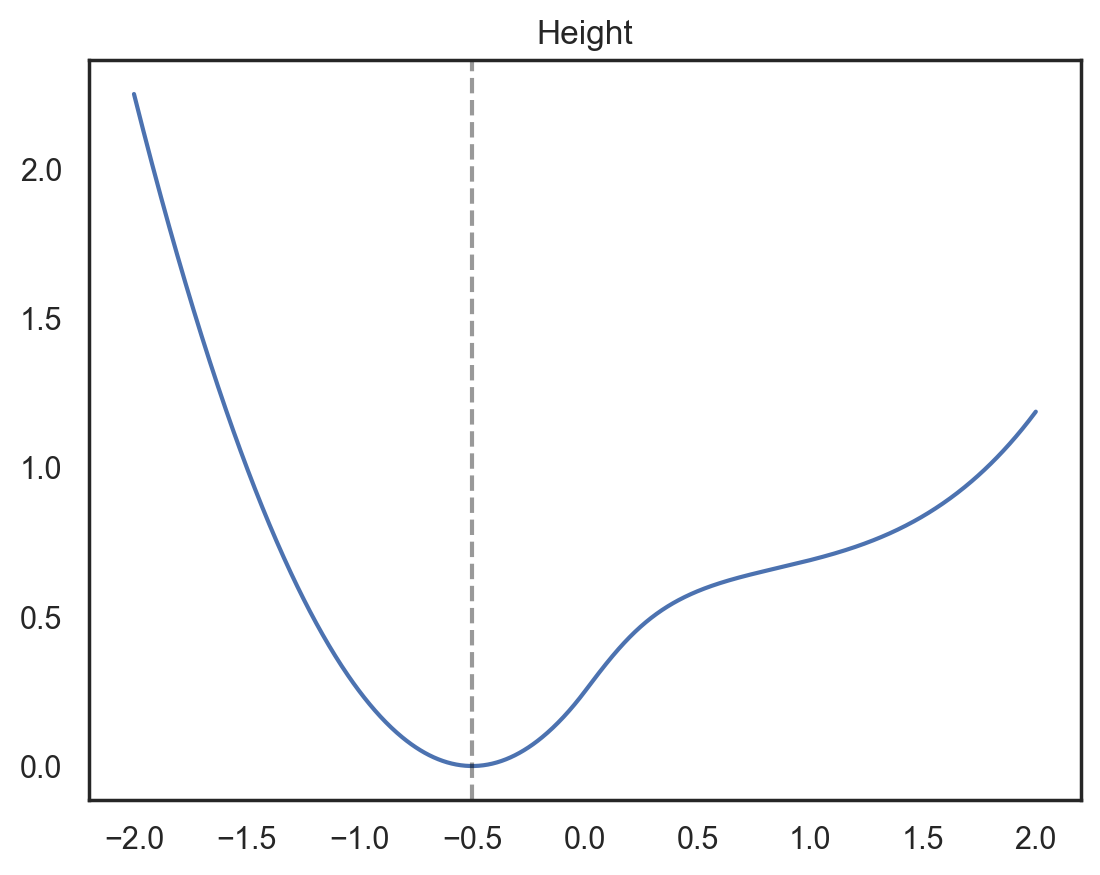

In [6]:
fig, ax = plt.subplots()
ax.plot(x_plot, [height(x) for x in x_plot])
ax.set_title("Height")
ax.axvline(-0.5, linestyle="--", color="black", alpha=0.4);

In [7]:
def phi(x):
    if x <= 0:
        return -2*x - 1
    else:
        return -(1+5*x**2)**(-3/2) - (1/8)*x**3

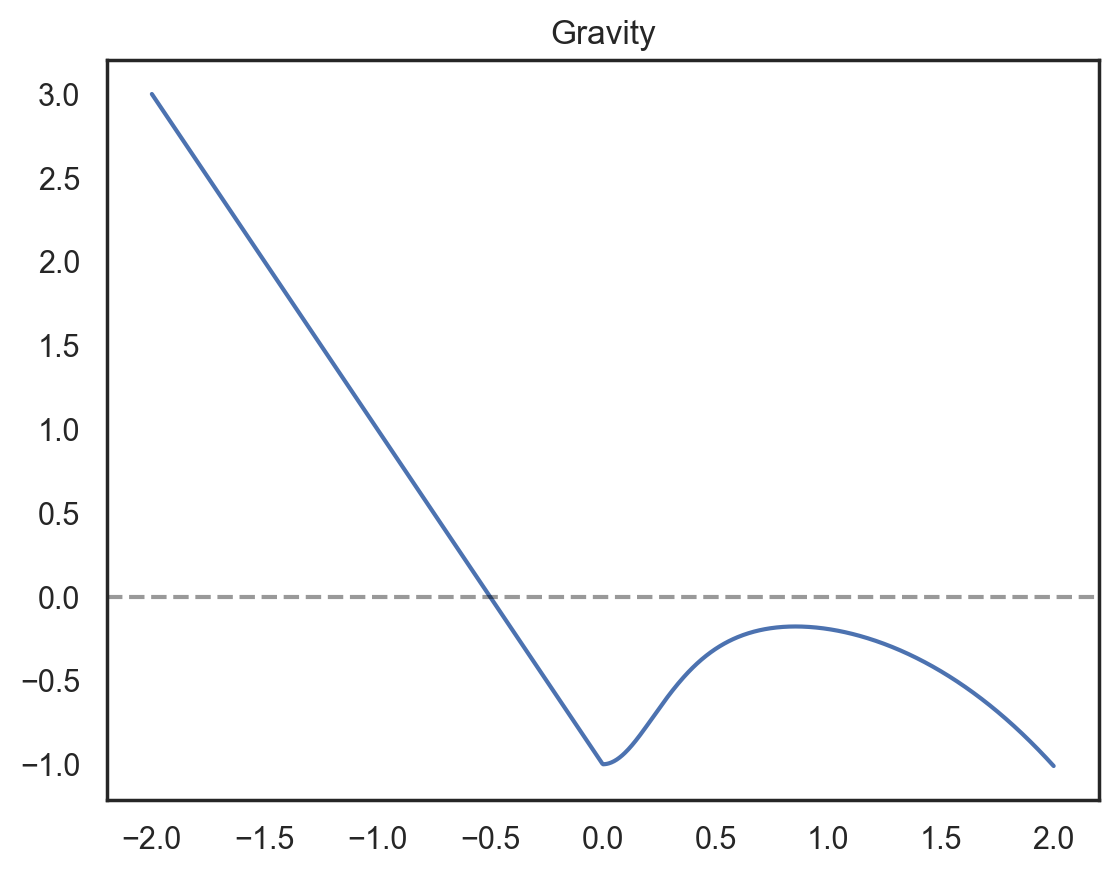

In [8]:
fig, ax = plt.subplots()
ax.plot(x_plot, [phi(x) for x in x_plot])
ax.axhline(0, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gravity");

In [9]:
actions = np.arange(-2, 3)
actions

array([-2, -1,  0,  1,  2])

In [86]:
def update_position_and_velocity(position, velocity, action):
    force_action = np.tanh(action)
    force_friction = -(1/8) * velocity
    force_gravity = phi(position)
    force = force_gravity + force_friction + force_action
    velocity += force
    position += velocity
    return position, velocity

In [12]:
position, velocity = (-2.0, 0.0)
update_position_and_velocity(position, velocity, 0)

NameError: name 'update_position_and_velocity' is not defined

In [ ]:
position, velocity = update_position_and_velocity(position, velocity, 2)
position, velocity

## Gym

In [ ]:
import gym

In [ ]:
env = gym.make("MountainCar-v0")

In [ ]:
env.reset()

In [ ]:
env.step(2)

In [ ]:
x_gym = np.linspace(-1.2, 0.6, 100)

fig, ax = plt.subplots()
ax.plot(x_gym, -0.0025 * np.cos(3*x_gym))
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.hlines(0., xmin=x_gym[0], xmax=x_gym[-1], linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - gravity");

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200, color="C1")
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - height");

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200)
ax.set_title("Gym mountain car");

In [ ]:
def dynamics_gym(position, velocity, action, gravity=0.0025, force=0.001):
    assert action in [-1, 0, 1], "Action needs to be either -1, 0, or 1"
    velocity += action*force - np.cos(3 * position) * gravity
    position += velocity
    return position, velocity

In [ ]:
position, velocity = -np.pi/6, 0
actions = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
for i, action in enumerate(actions):
    position, velocity = dynamics_gym(position, velocity, action)
    velocity = np.clip(velocity, -0.07, 0.07)
    position = np.clip(position, -1.2, 0.6)
    print(i, action, position, velocity)

# Convolution

In [352]:
delta_t = 2
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

In [321]:
def forward_motion(motion, action, delta_t):
    
    def _equations_of_motion(t, x, *args):
        action,  = args
        position, velocity = x    
        force_action = np.tanh(action)

        force_friction = -(1/8) * velocity

        if position <= 0:
            force_gravity = -2*position - 1
        else:
            # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
            force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

        force = force_gravity + force_friction + force_action
        change_in_velocity = force
        change_in_position = velocity
        dy = np.array([change_in_position, change_in_velocity])
        return dy

    sol = scipy.integrate.solve_ivp(
        fun=_equations_of_motion, 
        y0=motion,
        args=(action, ), 
        t_span=[0, delta_t, ],
        t_eval=[delta_t, ])
    return sol.y.reshape((2,))

In [344]:
coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
state_space_size = len(position_space) * len(velocity_space)
action_space_size = len(action_space)   

p = np.zeros((action_space_size, state_space_size, state_space_size))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(len(action_space)):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(state_space_size)
        s[idx_closest] = 1.
        
        p[idx_act, idx, :] =  s
        p[idx_act, idx, :] /= p[idx_act, idx, :].sum()

In [351]:
p_backward = np.zeros_like(p)
for idx_act in range(len(action_space)):
    p_backward[idx_act] = p[idx_act].T
    for idx in range(state_space_size):
        
        s = p_backward[idx_act, idx, :]
        s = s.reshape((len(position_space), len(velocity_space)))
        
        s_conv1 = scipy.signal.convolve(s, kernel, mode="same")
        s_conv2 = scipy.signal.convolve(s_conv1, kernel.T, mode="same")
        
        p_backward[idx_act, idx, :] = s_conv2.ravel()
        
        bwd_sum = p_backward[idx_act, idx].sum()
        
        if bwd_sum > 0:
            p_backward[idx_act, idx] /= bwd_sum # Normalize

In [346]:
def plot_belief(b, fig=None, ax=None, colorbar=True):
    
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    pos = ax.imshow(
        b.reshape(len(position_space), len(velocity_space)), 
        origin="lower", 
        extent=(min(position_space), max(position_space),
                min(velocity_space), max(velocity_space)),
        aspect=(max(position_space)-min(position_space)) 
            /(max(velocity_space)-min(velocity_space)))
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    if colorbar:
        fig.colorbar(pos)

### Few tests

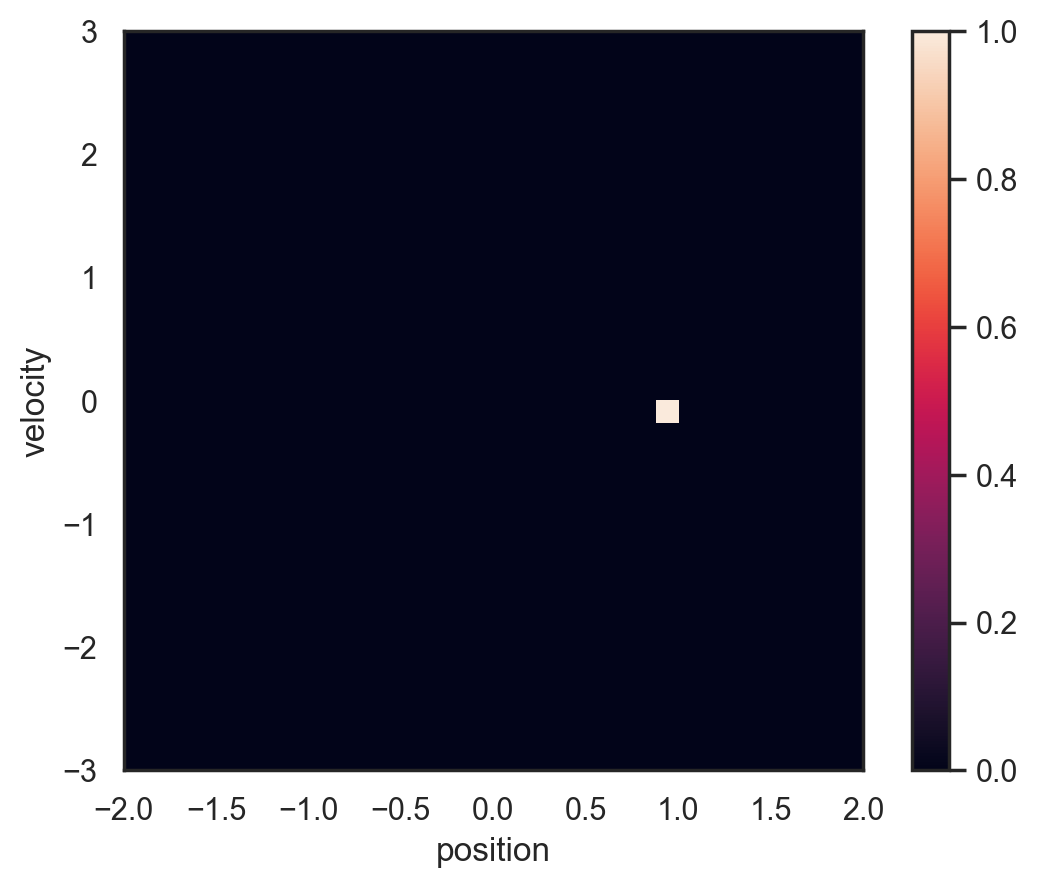

In [347]:
starting_motion = np.array([1., 0.])
dist, idx = tree.query(starting_motion)
idx_act = 0

b = np.zeros(state_space_size)

b[idx] = 1.
plot_belief(b)

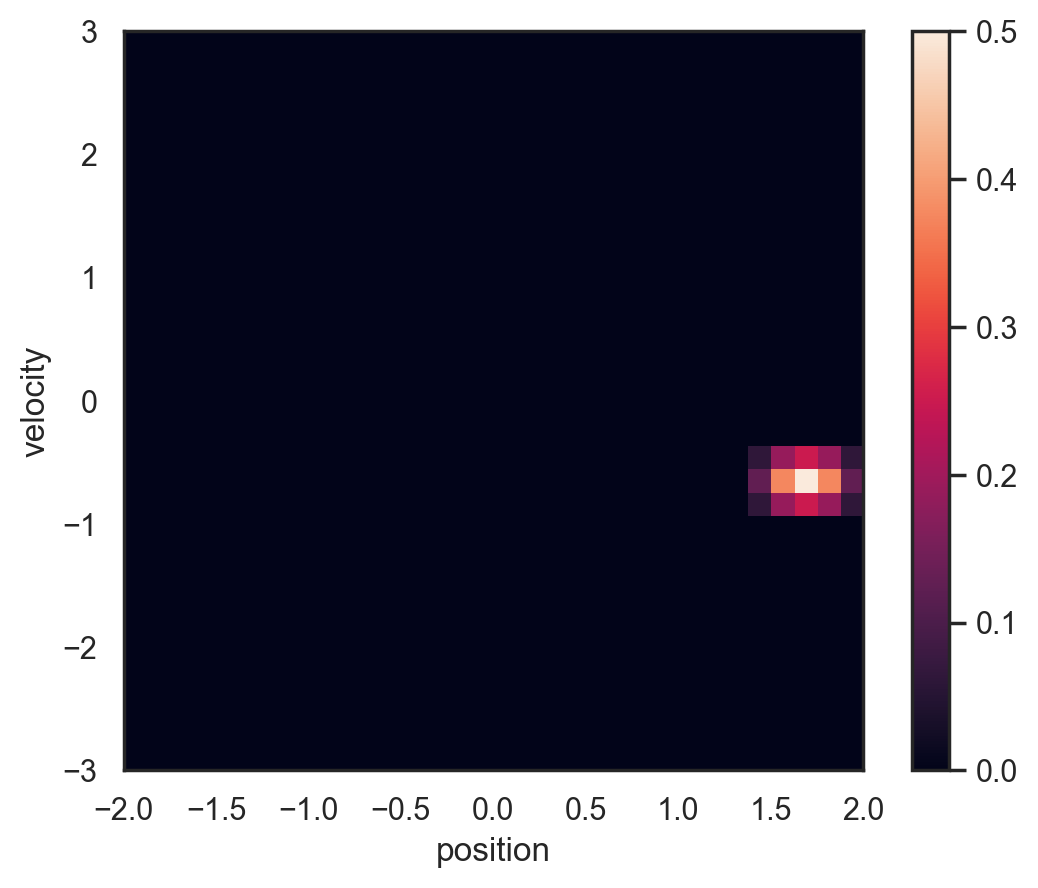

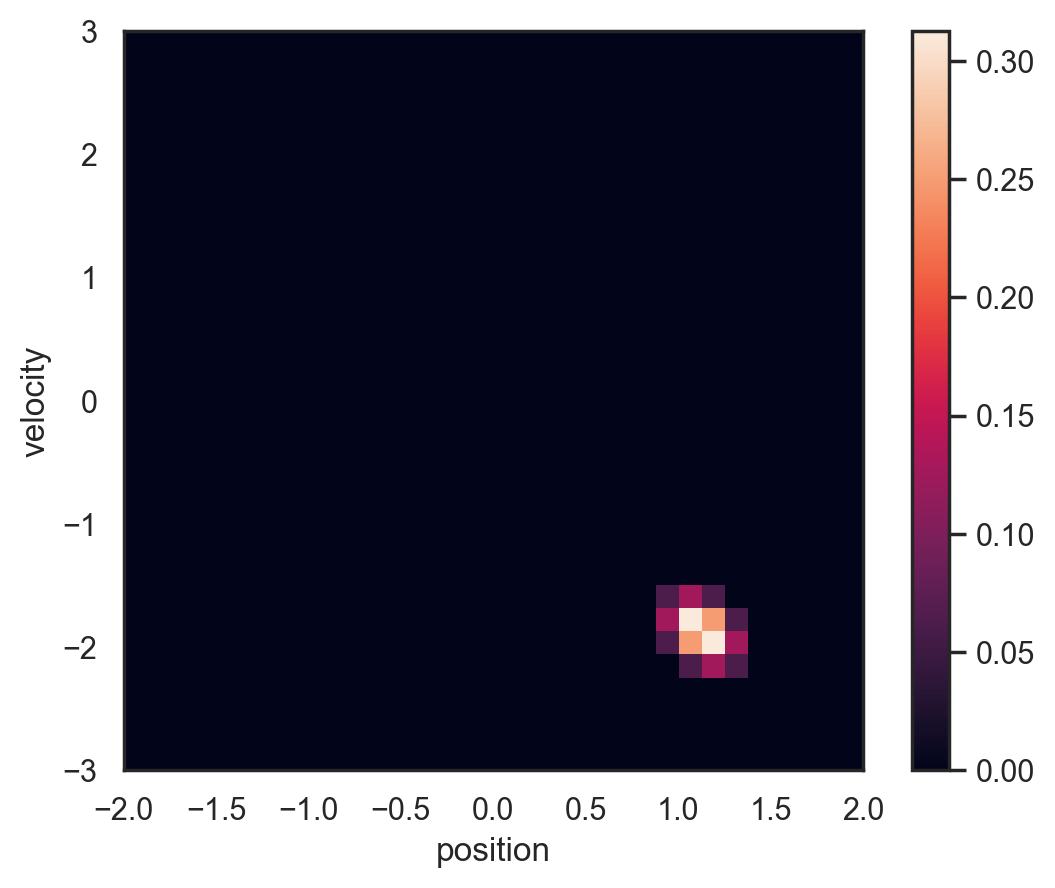

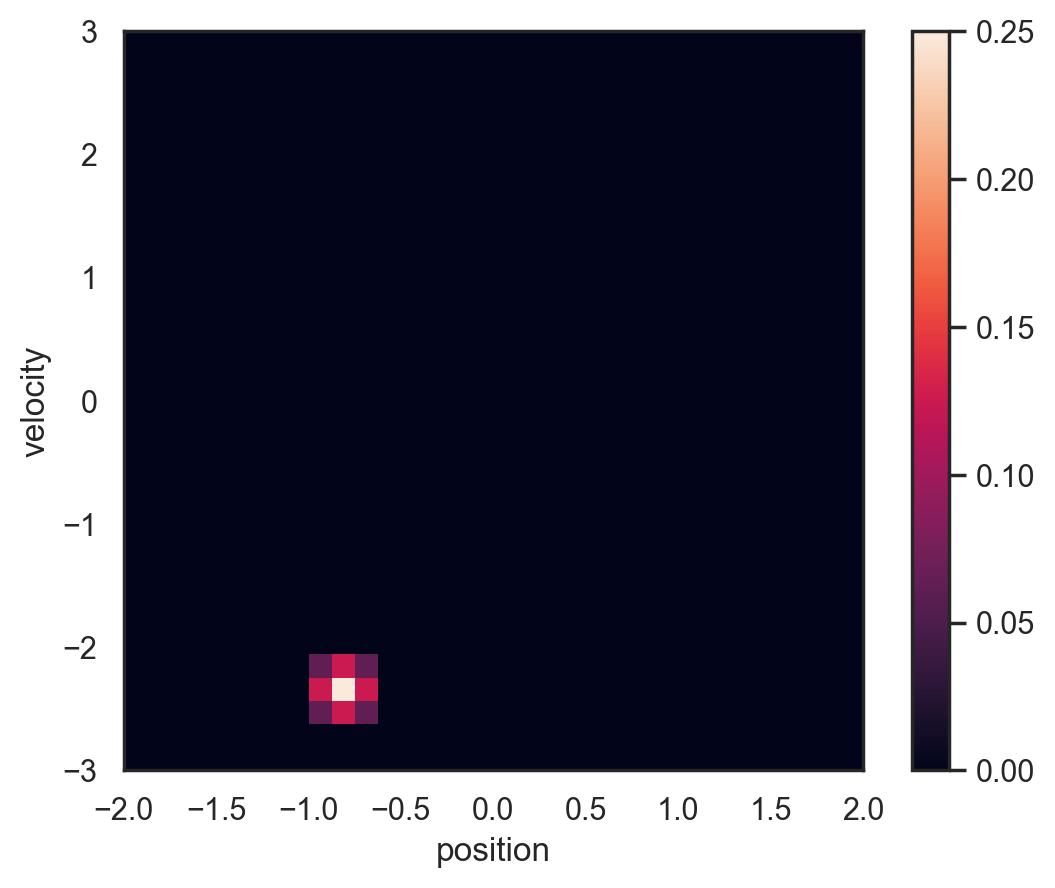

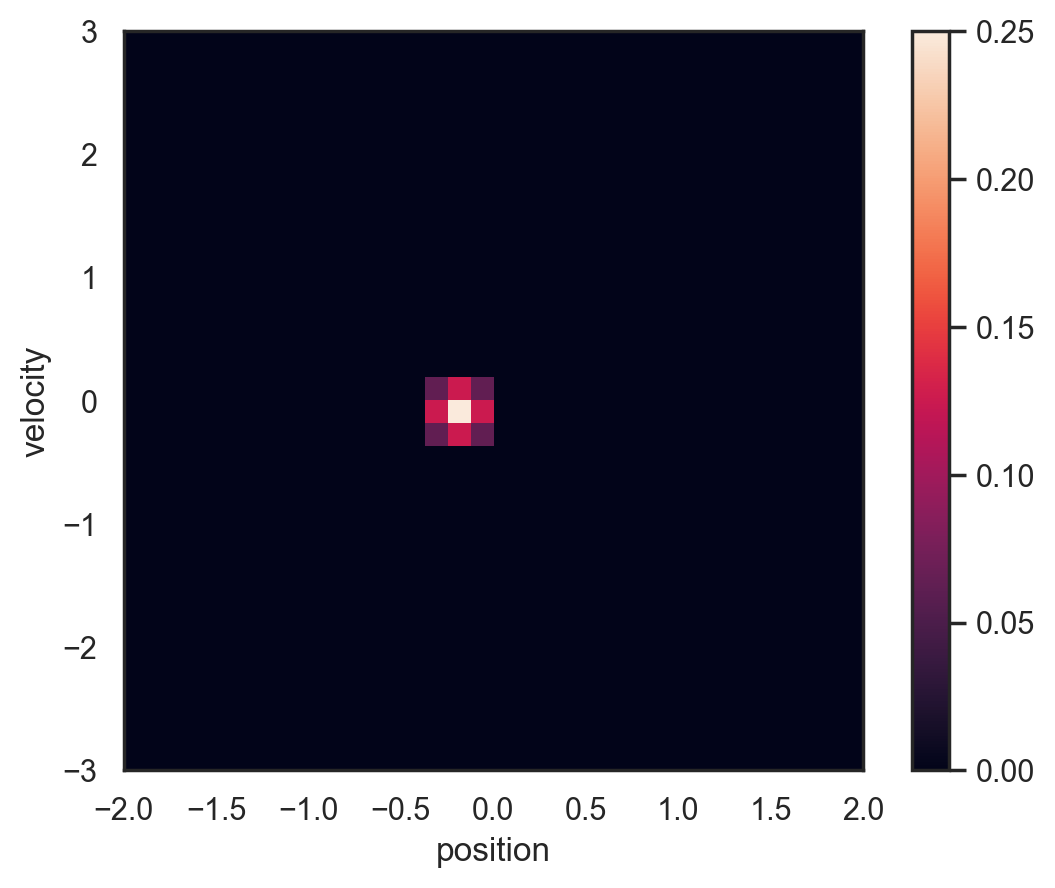

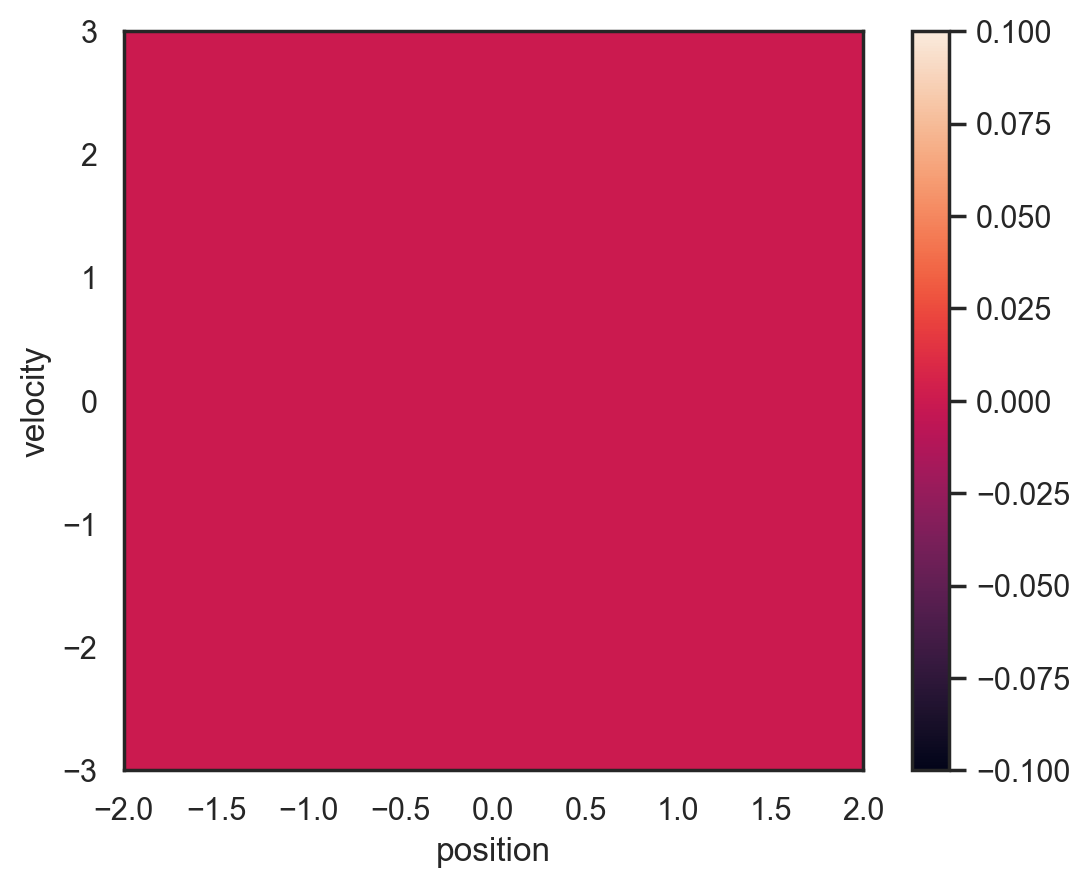

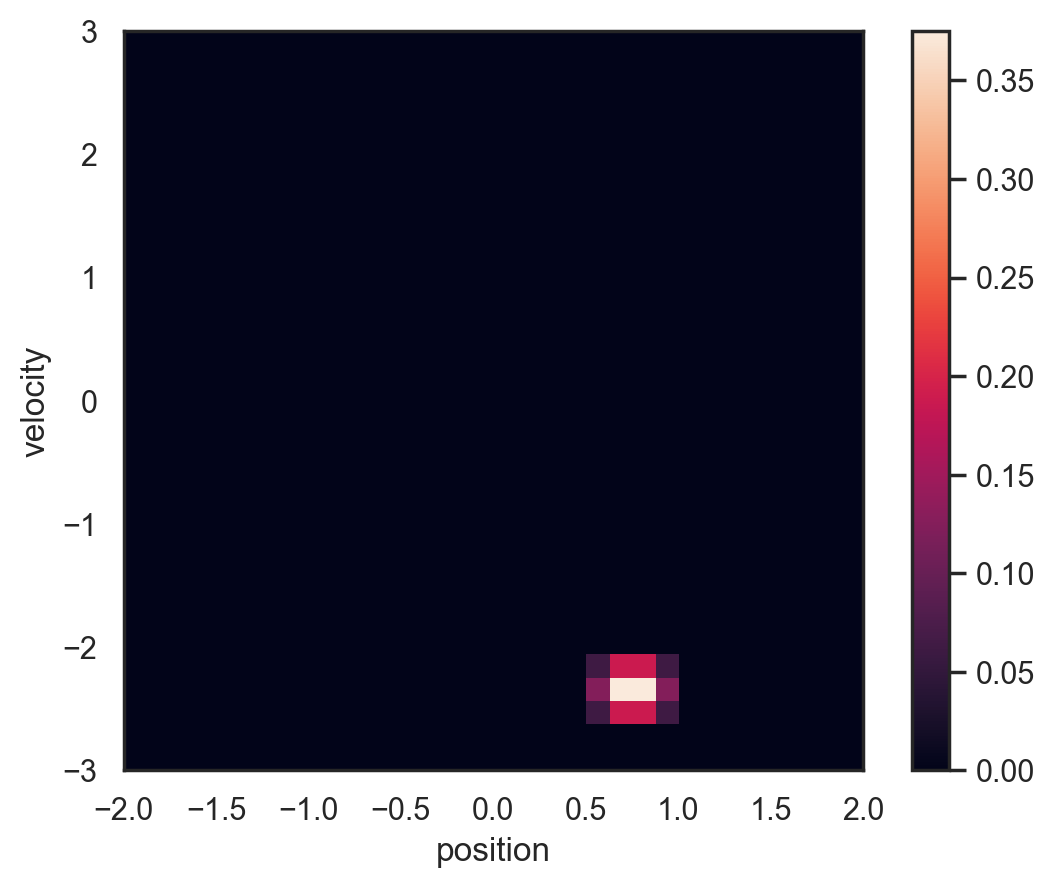

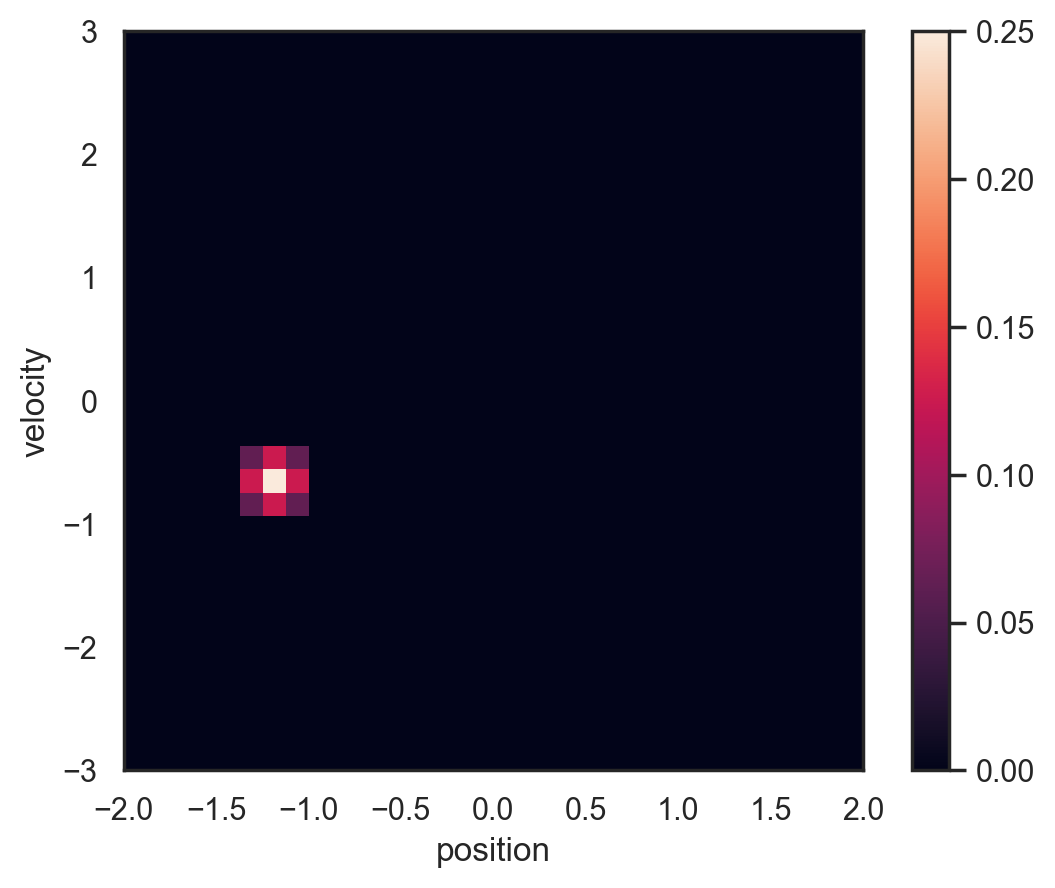

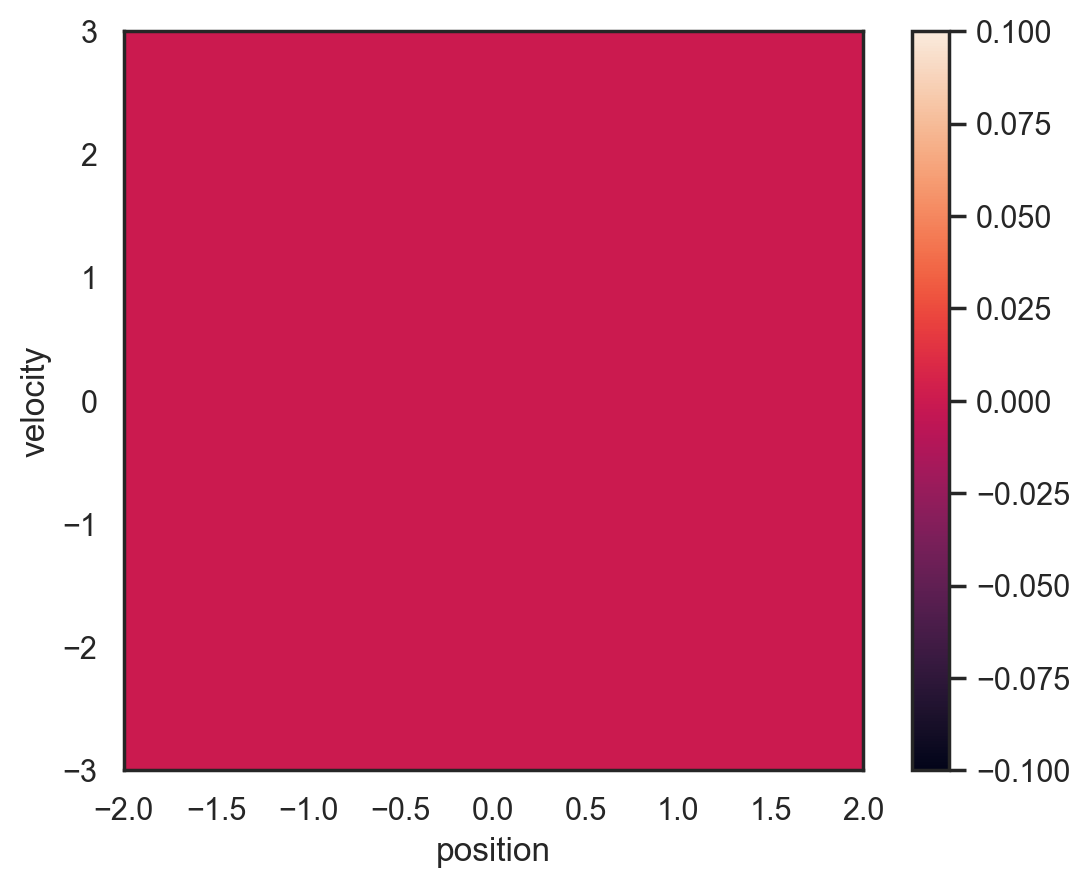

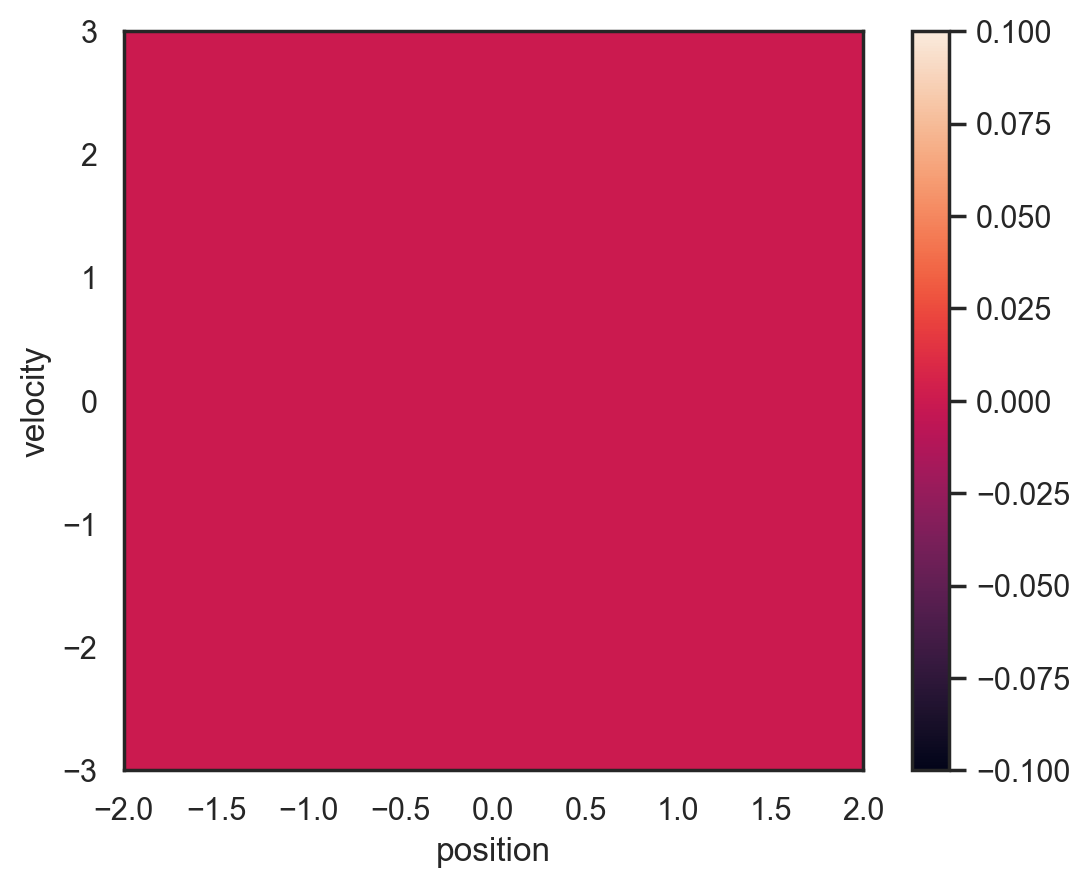

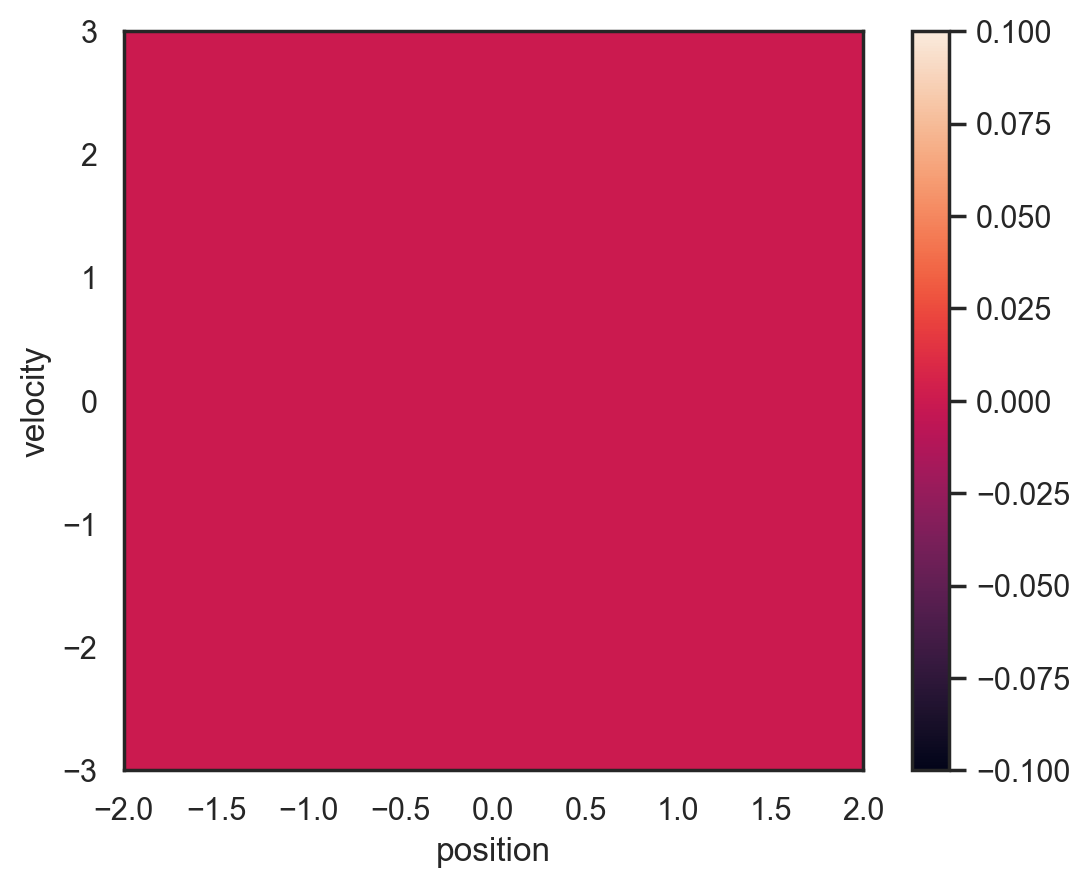

In [348]:
b = np.zeros(state_space_size)
dist, idx = tree.query(starting_motion)
b[idx] = 1

idx_act = np.where(action_space == 0)[0][0]

for idx in np.random.choice(np.arange(state_space_size), size=10):
    plot_belief(p_backward[idx_act, idx, :])

## Getting data

In [349]:
n_steps_variations = [0, 4, 8]

b_plot = np.zeros((len(action_space), len(n_steps_variations), state_space_size))


for idx_act in range(len(action_space)):

    # action = -2
    starting_motion = np.array([1.0, 0.0])

    b = np.zeros(state_space_size)
    dist, idx = tree.query(starting_motion)
    b[idx] = 1
    
    step = 0
    while True:
        if step in n_steps_variations:
            b_plot[idx_act, n_steps_variations.index(step), :] = b
            if step == n_steps_variations[-1]:
                break
        
        new_b = np.zeros_like(b)
        for idx_future in range(state_space_size):
            for idx_past in range(state_space_size):
                new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_future, idx_past]

        b = new_b
        step += 1

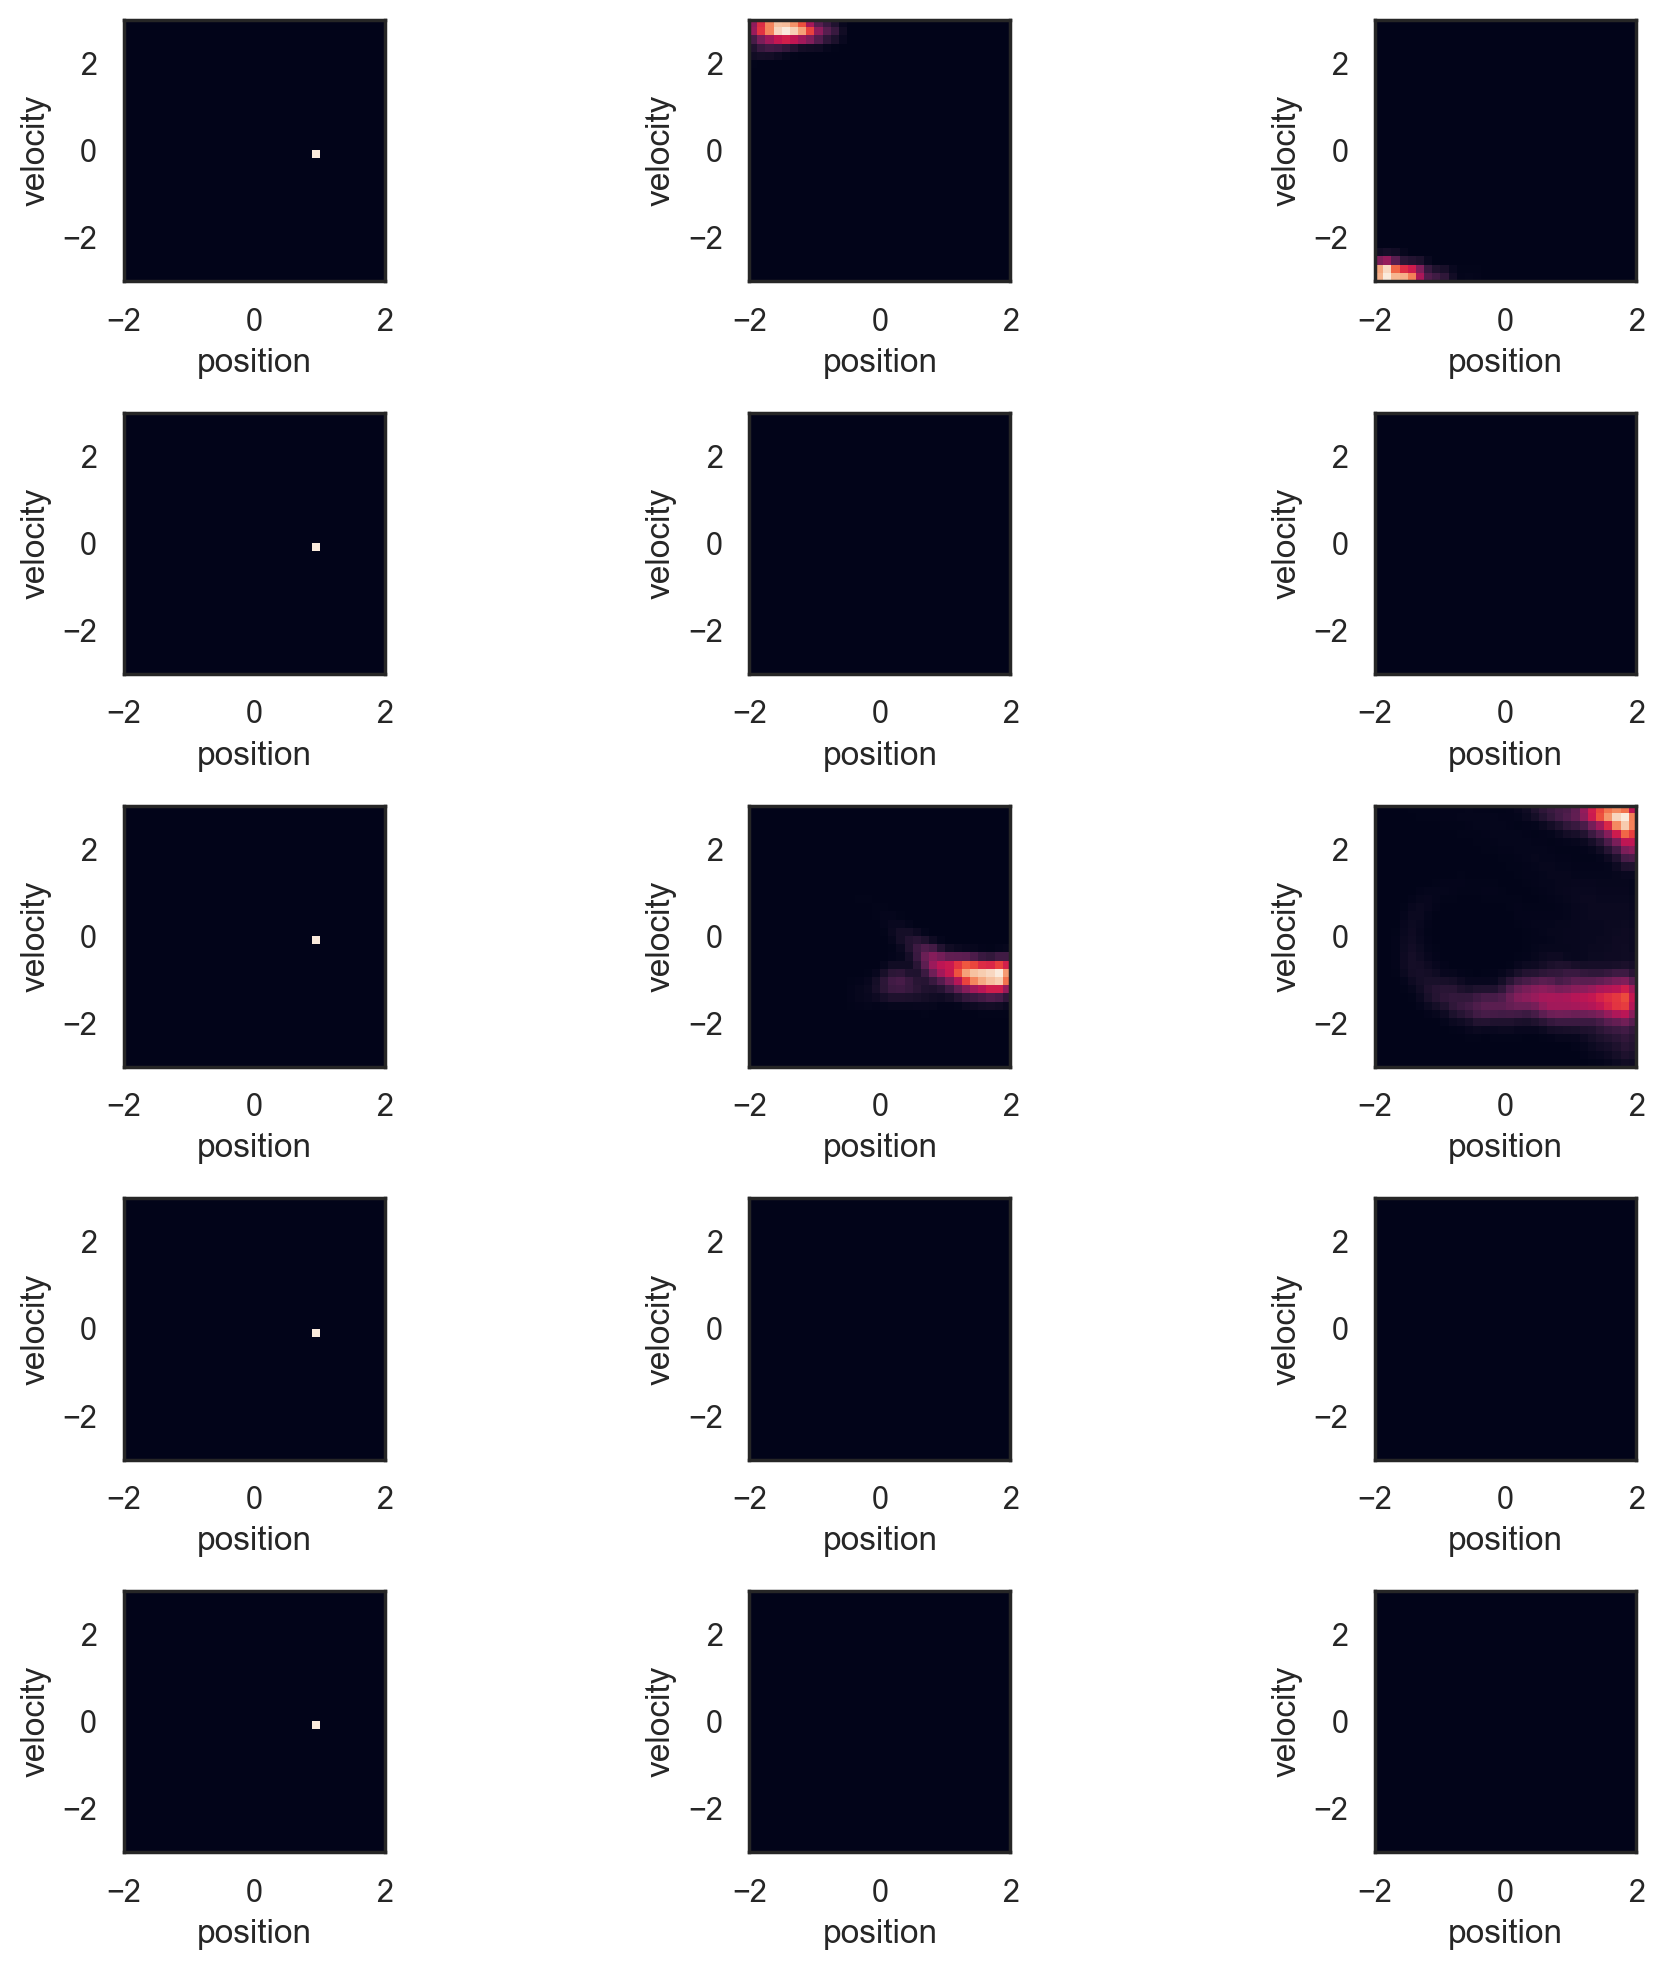

In [350]:
fig, axes = plt.subplots(nrows=len(action_space), ncols=len(n_steps_variations), figsize=(10, 10))

for idx_col, n_steps in enumerate(n_steps_variations):
    for idx_row, action in enumerate(action_space):

    
        plot_belief(b_plot[idx_row, idx_col], 
                    ax=axes[idx_row, idx_col], fig=fig, colorbar=False)

plt.tight_layout()